## Differentiating users based on their onchain interactions

We will take all wallets who have interacted with a given contract address, and see if we can add "features" to spot different clusters of wallets. A feature is just some characteristic/variable, such as if a wallet has an ENS domain registered or not.

This can be done in four steps:
1. Write a query on Dune where the returned data has columns for each feature and rows for each wallet 
2. Add parameters for "contract_address", "blockchain", and "minimum calls"
3. Use the dune-client to pull the data for Artblocks Curated NFT collection (at `0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270`)
4. Use scikit-learn and pandas to cluster the data (using k-means)

I've already [written the query here](https://dune.com/queries/3070841):

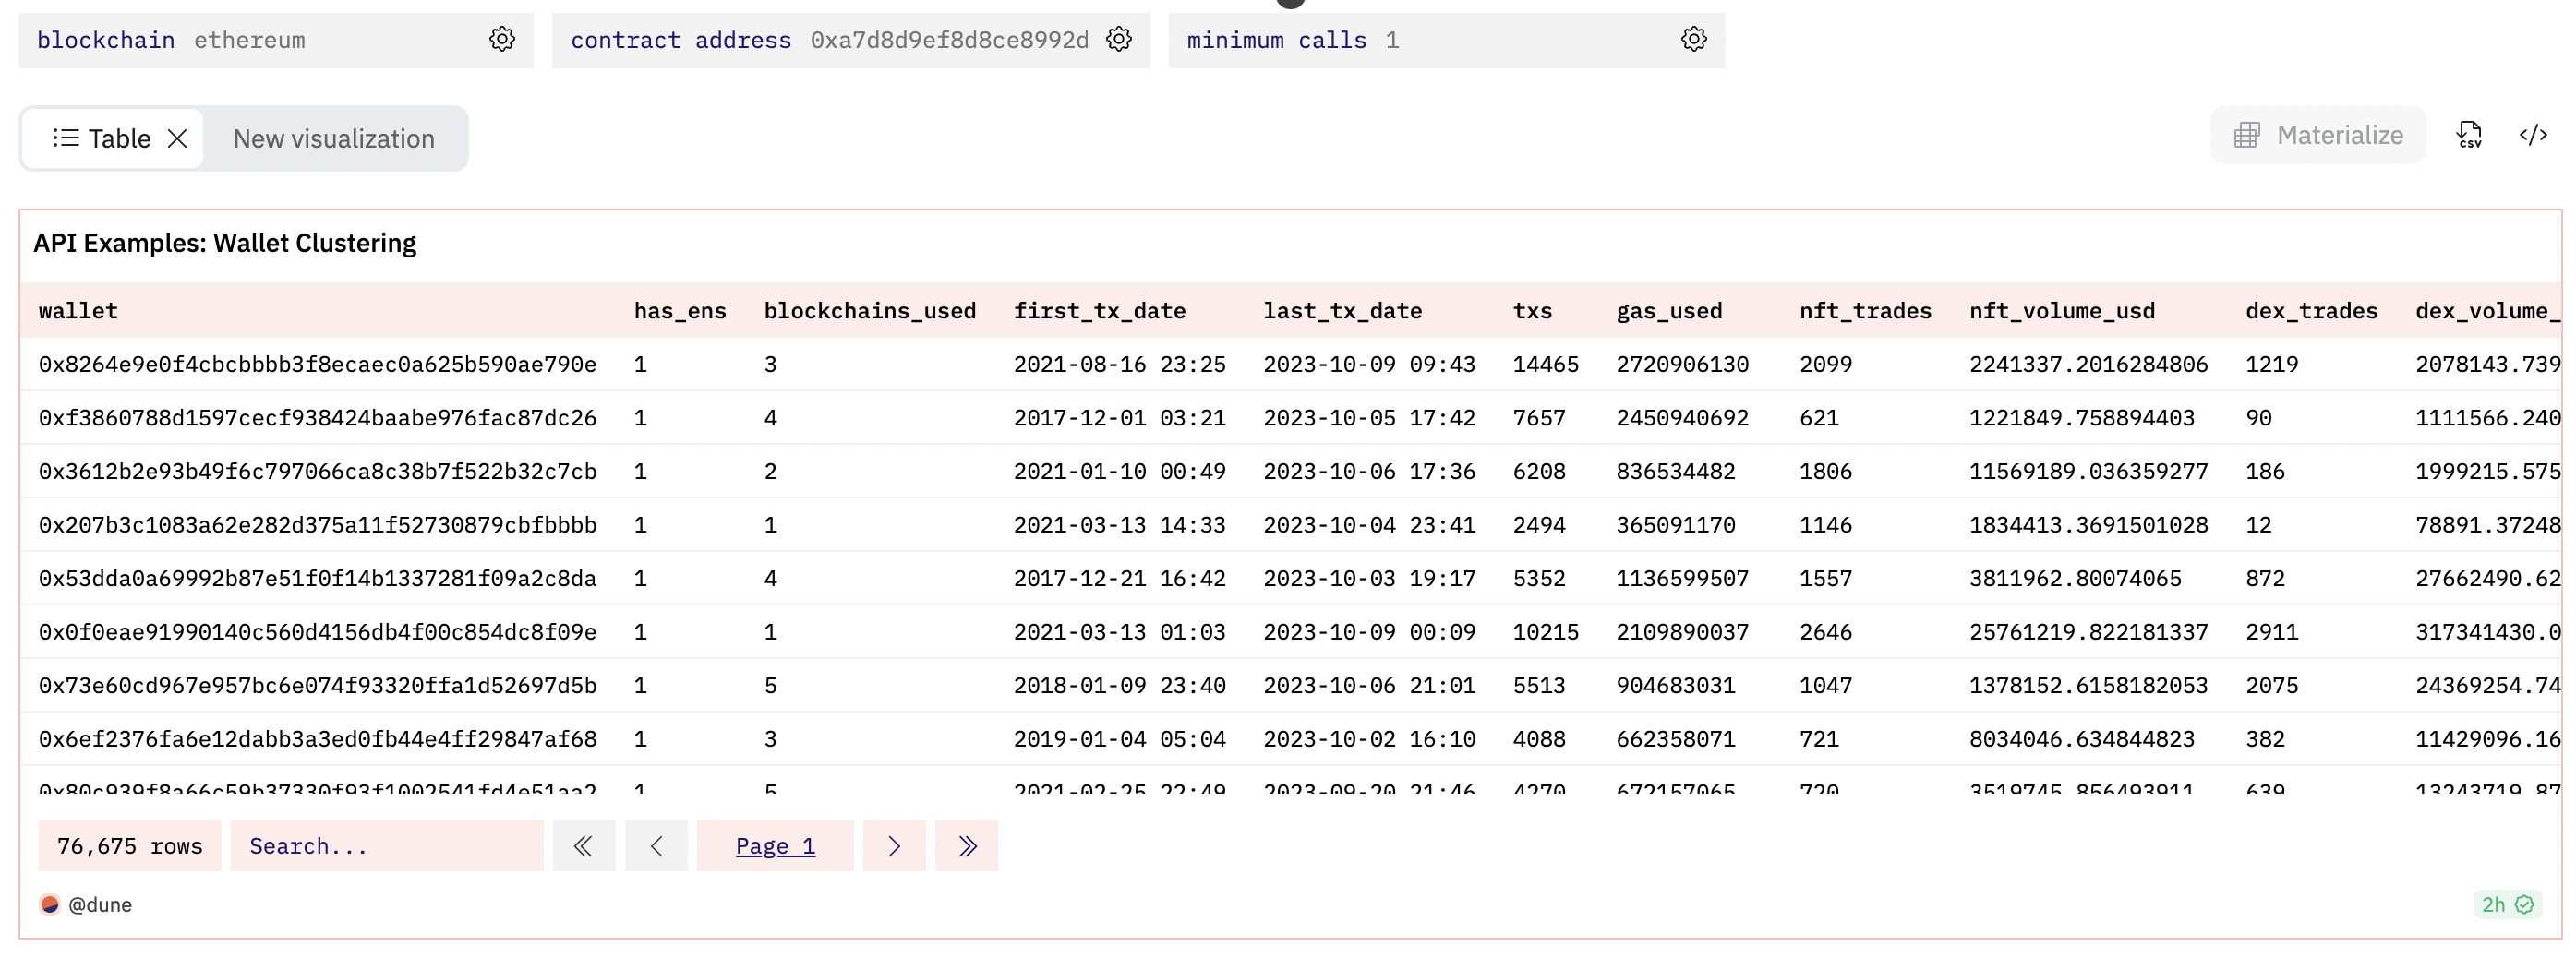

This query uses the following data sources:
- ENS spell
- dex.trades and nft.trades
- CEX address labels
- Raw transactions

## Pulling the data from the API

Let's run the query for Artblocks on Ethereum, for anyone who has called their contract at least once.

In [12]:
import warnings
warnings.filterwarnings("ignore")

from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase

from dotenv import load_dotenv
import pandas as pd
import numpy as np

#you should use a .env file for your api key
load_dotenv()
dune = DuneClient.from_env()

#putting in our parameters
query = QueryBase(
    query_id=3070841,
    params=[
        QueryParameter.text_type(name="blockchain", value="ethereum"),
        QueryParameter.text_type(name="contract address", value="0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270"),
        QueryParameter.number_type(name="minimum calls", value=1),
    ],
)

dune = DuneClient.from_env()
# results = dune.run_query(query) #does a fresh run of the query, default is on medium engine.

results = dune.get_latest_result(query, max_age_hours=8) #use this to get results from the last run, instead of re-running it
query_result = pd.DataFrame(results.result.rows)
query_result.head(1)

,blockchains_used,dex_trades,dex_volume_usd,first_tx_days_ago,funding_sources,gas_used,last_tx_days_ago,nft_trades,nft_volume_usd,times_called,times_cex_funded,times_funded,txs
0,3.0,1220.0,2.079163e+06,784.0,35.0,2.729417e+09,0.0,2105.0,2.241868e+06,2665,109.0,809.0,14500.0


You can see the features (columns) we're working with below. Hopefully the column names are self explanatory!

In [2]:
query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76676 entries, 0 to 76675
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   blockchains_used   76664 non-null  float64
 1   dex_trades         76664 non-null  float64
 2   dex_volume_usd     76664 non-null  float64
 3   first_tx_days_ago  76664 non-null  float64
 4   funding_sources    76664 non-null  float64
 5   gas_used           76664 non-null  float64
 6   last_tx_days_ago   76664 non-null  float64
 7   nft_trades         76664 non-null  float64
 8   nft_volume_usd     76664 non-null  float64
 9   times_called       76676 non-null  int64  
 10  times_cex_funded   76664 non-null  float64
 11  times_funded       76664 non-null  float64
 12  txs                76664 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 7.6 MB


It costs 10 credits to run on the medium engine in 1 minute, and costs 1700 credits (1 credit per 1000 datapoints) for the 17x100000 datapoints I will be exporting. You're given 2500 free tier credits.

You can also run it with free tier in app, and then use the get latest results endpoint (which is what I did above).

## Cleaning the Data

Let's get a quick summary of the data to see if we need to remove outliers or apply any transforms.

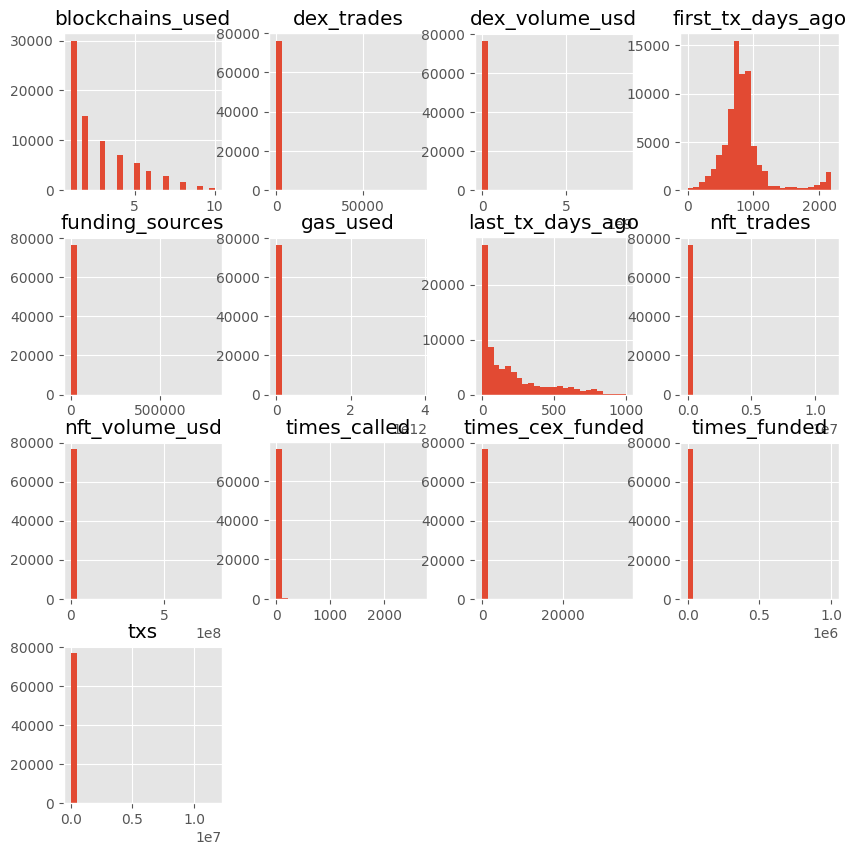

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(False)
query_result.hist(bins=25, ax=ax)
plt.show()

There are clearly some wild outliers in many of these features, so we will need to take the log transform of some of these values 

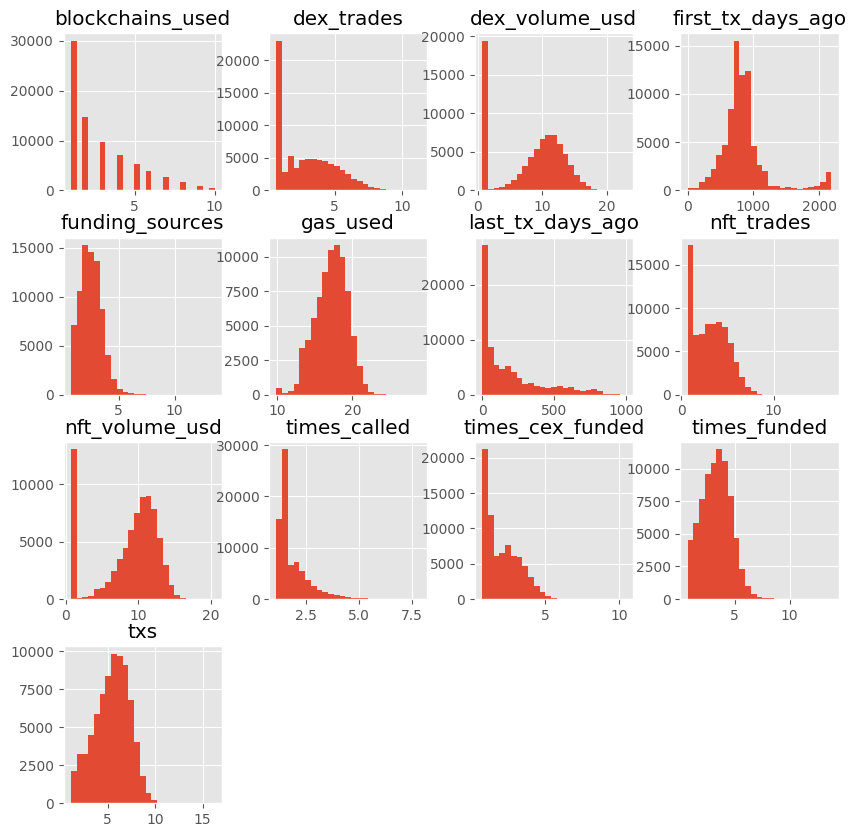

In [4]:
query_result_tf = query_result
query_result_tf.dropna(inplace=True)

log_transform_columns = ['dex_trades', 'dex_volume_usd', 'funding_sources',
       'gas_used', 'nft_trades', 'nft_volume_usd', 'times_called',
       'times_cex_funded', 'times_funded', 'txs']

query_result_tf[log_transform_columns] = query_result_tf[log_transform_columns].applymap(lambda x: np.log1p(x + 1))

#let's plot again
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(False)
query_result.hist(bins=25, ax=ax)
plt.show()

There we go! Now this looks log normal, so we can move on.

In [5]:
#standard normal scalar, then don't use PCA
from sklearn.preprocessing import StandardScaler

numerics = ['int32','int64','float64']
query_result_tf = query_result_tf.select_dtypes(include=numerics)

scaled_features = StandardScaler().fit_transform(query_result_tf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=query_result_tf.index, columns=query_result_tf.columns)
scaled_features_df.head()

,blockchains_used,dex_trades,dex_volume_usd,first_tx_days_ago,funding_sources,gas_used,last_tx_days_ago,nft_trades,nft_volume_usd,times_called,times_cex_funded,times_funded,txs
0,0.108798,2.067771,1.252747,-0.174372,1.161136,2.109658,-0.854826,2.449866,1.426910,7.968071,2.258929,2.594040,2.270952
1,0.587498,0.779162,1.128571,3.612858,2.340422,2.059422,-0.836317,1.787696,1.282208,7.849251,1.193204,1.538616,1.923324
2,-0.369903,1.135213,1.244971,0.438186,1.988707,1.557629,-0.840944,2.366696,1.818153,6.966820,1.772333,1.308558,1.809126
3,-0.848603,-0.158841,0.603976,0.261971,1.132643,1.170631,-0.854826,2.119864,1.379089,6.899714,0.784183,0.627847,1.313025
4,0.587498,1.900788,1.765975,3.556917,1.534857,1.700717,-0.827062,2.286170,1.553468,6.878442,0.691254,1.023403,1.728364


## Clustering the wallets

Now that we have transformed our data, we can go ahead and cluster. Let's use the [k-means algorithim](https://machinelearningmastery.com/clustering-algorithms-with-python/), which creates clusters that have minimum variance within each cluster. You can choose any number of clusters, usually having to play around with it. I like to visually explore it, but you can use a more deterministic method like a [silhouette score](https://saturncloud.io/blog/how-to-use-silhouette-score-in-kmeans-clustering-from-scikitlearn-library/#:~:text=The%20silhouette%20score%20is%20a%20useful%20metric%20for%20evaluating%20the,is%20from%20the%20neighboring%20clusters).

In [6]:
import numpy as np
import os
import pdb

# to make this notebook's output stable across runs
np.random.seed(42)

'''unsupervised classifiers'''
from sklearn.cluster import KMeans
from sklearn import metrics

k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(scaled_features_df)

query_result["clusters"] = y_pred #add the clusters to the original dataframe

#calculate silhouette with a sample of the data
silhouette_avg = metrics.silhouette_score(scaled_features_df
                                          , y_pred
                                          , metric="euclidean"
                                          , sample_size=1000,)
print('The average silhouette score is:', silhouette_avg)

The average silhouette score is: 0.23578339068248913


0.24 score is okay, kind of the minimum to say there are separate clusters.

Let's do a pivot table on clusters to spot quick differences:

In [7]:
table = pd.pivot_table(query_result
                        , values=['nft_trades','dex_trades','last_tx_days_ago','first_tx_days_ago','times_funded','times_called','blockchains_used']
                        , index=['clusters']
                        , aggfunc=lambda x: int(round(np.median(x),0)))
print(table)

          blockchains_used  dex_trades  first_tx_days_ago  last_tx_days_ago  \
clusters                                                                      
0                        5           5                927                16   
1                        1           1                700               327   
2                        2           3                780                97   

          nft_trades  times_called  times_funded  
clusters                                          
0                  5             2             5  
1                  1             1             2  
2                  3             2             3  


There is clearly a difference in age and activity of wallets, but the activity difference is honestly not drastic. We can plot their distributions as well just to see if it tells us anything else. You can tell cluster 0 (the long inactive group) has the most skewed distribution of the three clusters

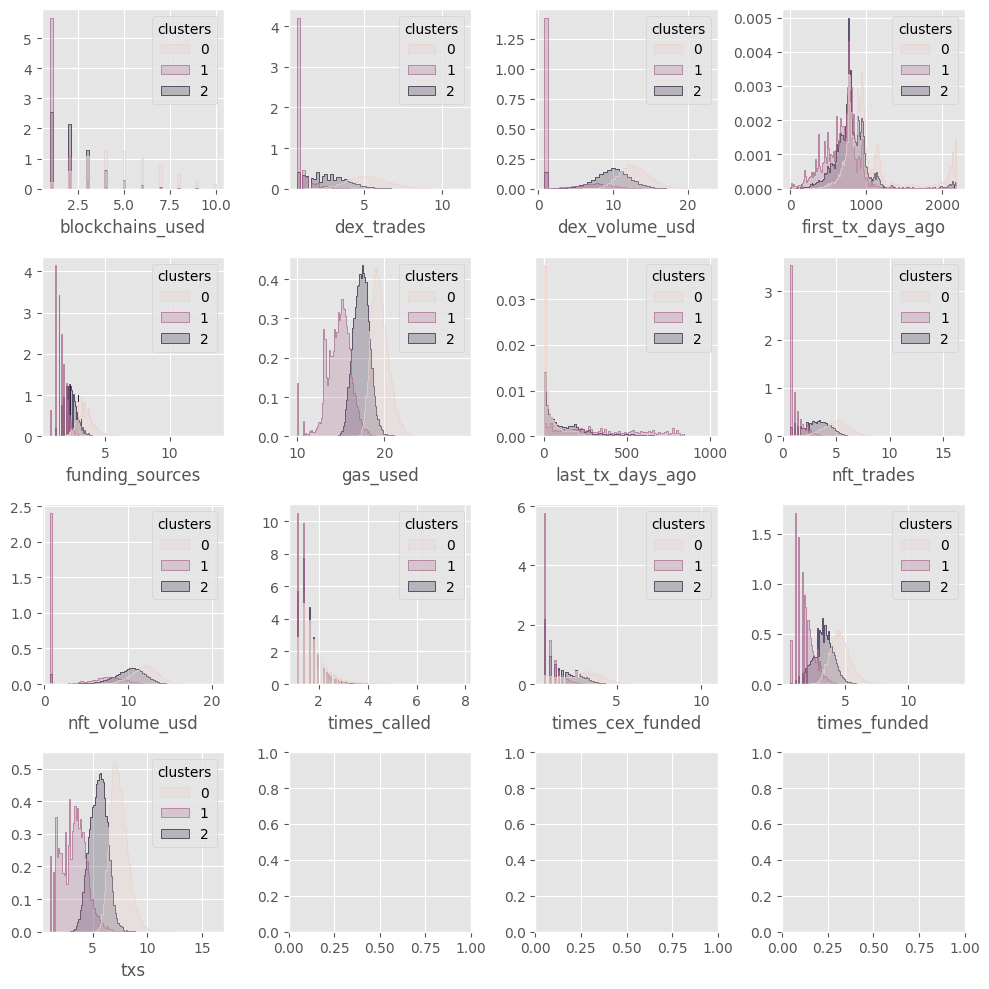

In [10]:
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(10, 10))

df_n = query_result.select_dtypes(include=numerics)

x=0
y=0
for idx, column in enumerate(df_n.columns[:-1]):
    # print(idx, column)
    # print(x,y)
    sns.histplot(
        df_n, x=column, hue="clusters", element="step",
        stat="density", common_norm=False, ax = ax[x,y]
    )
    # ax[x,y].set_title(column,fontweight="bold", size=10)
    ax[x,y].set_ylabel('')
    if y == 3:
        y = 0
        x+=1
    else:
        y+=1
        
plt.tight_layout()
plt.show()

## Takeaways, and what comes next?

Age and activity of wallets seem to be the best features for clustering wallet groups. There are three main clusters:
- wallets that have long been inactive
- wallets that are intermittenly active
- wallets that are very active.

Go add fork the query and add more features, change the contract to another token or a protocol like Opensea or Uniswap, change the number of clusters, etc.

Have fun, and please reach out if you have any questions :)